In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio 
import h5py
from v1_data import V1
import os
import os.path

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, BatchNormalization, GRU, CuDNNLSTM, Flatten, Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras.optimizers import RMSprop, SGD, Adam
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
import time 

from tf_utils import neglogli, poiss_full, get_bps, r2, restore_performance_checkpt, color
from nn_models import gen_fc_model, gen_rnn_model, gen_cnn_model

# set plots inside notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

N_COMPLEX = len(os.listdir('./RustV1/complex/data/'))
N_SIMPLE = len(os.listdir('./RustV1/simple/data/'))
cell_nums = {'simple':N_SIMPLE, 'complex':N_COMPLEX}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
N_SIMPLE

3

In [4]:
ln_fs = [0,1,2,3,4,5]

h_layers_fc = [0,1,2,3]
h_sizes_fc = [1,2,3,4,5,16,32,64,128]

h_layers_rnn = [0,1,2]
h_sizes_rnn = [2,5,10,25,50]

h_layers_cnn = [0,1,2,3]
h_sizes_cnn = [2,4,8,16,32,64]

hparams = {'fc':{'h_layers':h_layers_fc, 'h_sizes':h_sizes_fc, 'ndepths':len(h_layers_fc), 'nwidths':len(h_sizes_fc)},
          'rnn':{'h_layers':h_layers_rnn, 'h_sizes':h_sizes_rnn, 'ndepths':len(h_layers_rnn), 'nwidths':len(h_sizes_rnn)},
          'cnn':{'h_layers':h_layers_cnn, 'h_sizes':h_sizes_cnn, 'ndepths':len(h_layers_cnn), 'nwidths':len(h_sizes_cnn)}}

In [8]:
celltype = 'simple'
model_type = 'fc'
plot = True 
gen_psth = False
restore_frm_chkpt = False
v1 = V1(celltype, 1)

ndepths = hparams[model_type]['ndepths']
nwidths = hparams[model_type]['nwidths']
nfilts = len(ln_fs)

performance_bps = np.zeros([ndepths, nwidths, cell_nums[celltype]])
performance_r2 = np.zeros([ndepths, nwidths, cell_nums[celltype]])
filter_bps = np.zeros([nfilts])
filter_r2 = np.zeros([nfilts])
best_r2 = -1.
best_bps = -1.

if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    performance_bps = restore_performance_checkpt('./SavedResults/' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    performance_bps = performance_bps.reshape(ndepths, nwidths, cell_nums[celltype])
    best_bps = np.max(performance_bps)
    
    performance_r2 = restore_performance_checkpt('./SavedResults/' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    performance_r2 = performance_r2.reshape(ndepths, nwidths, cell_nums[celltype])
    best_r2 = np.max(performance_r2)
    

    
    
# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;


k = 0
for cell_num in [2]:#range(cell_nums[celltype]):
    v1 = V1(celltype, cell_num+1, flatten=flatten);
    i = 0
    for L in [2]:#hparams[model_type]['h_layers']:
        j = 0
        for H in [64]:#hparams[model_type]['h_sizes']:
            if performance_bps[i,j,k] == 0.:
                print ("============================================================")
                print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                       + " with depth of " + str(L+2) + " and width of " + str(H) + color.END) 
                model = gen_model[model_type](H, L=L, dim=v1.X_train.shape[-1])

                hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=10+L*4,
                                 verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
                time.sleep(0.1)

                bps,_ = get_bps(model, v1)
                _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

                if bps > best_bps:
                    best_bps = bps
                    print (color.PURPLE + 'saving new bps model...' + color.END)
                    model.save('SavedModels/' + celltype + '_best_' + model_type + '_bps.h5')

                if rsq > best_r2:
                    best_r2 = rsq
                    print (color.PURPLE + 'saving new r2 model...' + color.END)
                    model.save('SavedModels/' + celltype + '_best_' + model_type + '_r2.h5')

                performance_bps[i,j,k] = bps
                performance_r2[i,j,k] = rsq

                if gen_psth:
                    rpt_preds = model.predict(v1.X_rpt)
                    model_psth = v1.convert_nn_psth(rpt_preds)

                    if plot:
                        plt.plot(model_psth, label='nn')
                        plt.plot(v1.psth, label='repeat')
                        plt.legend()
                        plt.xlabel('Time (ms)')
                        plt.ylabel('Rate (sp/s)')
                        plt.show()


                print ("bps: ", bps)
                print ("r2: ", rsq)
                print (" ")


            j += 1
            
            #print (color.BOLD + 'saving checkpoint...\n' + color.END)
            #np.savetxt('./SavedResults/' + celltype + '_' + model_type \
            #           + '_bps.csv', performance_bps.reshape(-1,1), delimiter=',')
            #np.savetxt('./SavedResults/' + celltype + '_' + model_type \
            #           + '_r2.csv', performance_r2.reshape(-1,1), delimiter=',')
        i += 1
    k += 1


building data...
fetching repeat data...
done.
building data...
fetching repeat data...
done.
Training Model on Cell 3 of 3 with depth of 4 and width of 64
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
activation_4 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_5 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)             

In [ ]:
ln_fs = [1,2,3,4,5]

s_fc_config = {'L':2, 'H':64}
s_rnn_config = {'L':2, 'H':50}
s_cnn_config = {'L':2, 'H':64}

c_fc_config = {'L':3, 'H':128}
c_rnn_config = {'L':2, 'H':25}
c_cnn_config = {'L':1, 'H':32}


params = {'fc':{'simple':s_fc_config, 'complex':c_fc_config},
          'rnn':{'simple':s_rnn_config, 'complex':c_rnn_config},
          'cnn':{'simple':s_cnn_config, 'complex':c_cnn_config}}

In [ ]:
celltype = 'simple'
model_type = 'fc'
plot = False 
gen_psth = False
restore_frm_chkpt = False
v1 = V1(celltype, 1)

ndepths = hparams[model_type]['ndepths']
nwidths = hparams[model_type]['nwidths']
nfilts = len(ln_fs)

pf_bps = np.zeros([nfilts, cell_nums[celltype]])
pf_r2 = np.zeros([nfilts, cell_nums[celltype]])
best_r2 = -1.
best_bps = -1.

if restore_frm_chkpt:
    print (color.BOLD + 'loading checkpoint...' + color.END)
    pf_bps = restore_performance_checkpt('./SavedResults/filts_' + celltype \
                                                  + '_' + model_type + '_bps.csv')
    pf_bps = pf_bps.reshape(nfilts, cell_nums[celltype])
    best_bps = np.max(pf_bps)
    
    pf_r2 = restore_performance_checkpt('./SavedResults/filts_' + celltype \
                                                 + '_' + model_type + '_r2.csv')
    pf_r2 = pf_r2.reshape(nfilts, cell_nums[celltype])
    best_r2 = np.max(pf_r2)
     
    
# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, min_delta=.1, verbose=1, mode='auto')
callbacks_list = [earlystop]

# model type
gen_model = {'fc':gen_fc_model, 'rnn':gen_rnn_model, 'cnn':gen_cnn_model}

# data format
if model_type in ['rnn', 'cnn']: flatten = False;
else: flatten = True;

H = params[model_type][celltype]['H']
L = params[model_type][celltype]['L']

i = 0
for cell_num in range(cell_nums[celltype]):
    j = 0
    for nf in ln_fs:
        if pf_bps[i,j] == 0.:
            print ("============================================================")
            print (color.BOLD + "Training Model on Cell " + str(cell_num+1) + " of " + str(cell_nums[celltype])  \
                   + " with " + str(nf) + " Filters" + color.END) 
            model = gen_model[model_type](H, L=L, LNP=nf, dim=v1.X_train.shape[-1])

            hist = model.fit(v1.X_train, v1.y_train, batch_size=50, epochs=10+L*4,
                             verbose=1, callbacks=None, validation_data=(v1.X_val, v1.y_val)) 
            time.sleep(0.1)

            bps,_ = get_bps(model, v1)
            _, rsq = r2(model.predict(v1.X_test).reshape(-1,), v1.y_test.reshape(-1,))

            if bps > best_bps:
                best_bps = bps
                print (color.PURPLE + 'saving new bps model...' + color.END)
                model.save('SavedModels/filts_' + celltype + '_best_' + model_type + '_bps.h5')

            if rsq > best_r2:
                best_r2 = rsq
                print (color.PURPLE + 'saving new r2 model...' + color.END)
                model.save('SavedModels/filts_' + celltype + '_best_' + model_type + '_r2.h5')

            pf_bps[i,j,k] = bps
            pf_r2[i,j,k] = rsq

            if gen_psth:
                rpt_preds = model.predict(v1.X_rpt)
                model_psth = v1.convert_nn_psth(rpt_preds)

                if plot:
                    plt.plot(model_psth, label='nn')
                    plt.plot(v1.psth, label='repeat')
                    plt.legend()
                    plt.xlabel('Time (ms)')
                    plt.ylabel('Rate (sp/s)')
                    plt.show()


            print ("bps: ", bps)
            print ("r2: ", rsq)
            print (" ")


        j += 1

        print (color.BOLD + 'saving checkpoint...\n' + color.END)
        np.savetxt('./SavedResults/filts_' + celltype + '_' + model_type \
                   + '_bps.csv', performance_bps.reshape(-1,1), delimiter=',')
        np.savetxt('./SavedResults/filts_' + celltype + '_' + model_type \
                   + '_r2.csv', performance_r2.reshape(-1,1), delimiter=',')


In [188]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights())
    
print len(weights)

5


(16,)


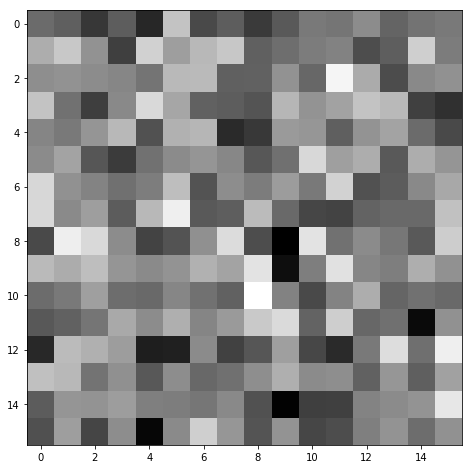

(16,)


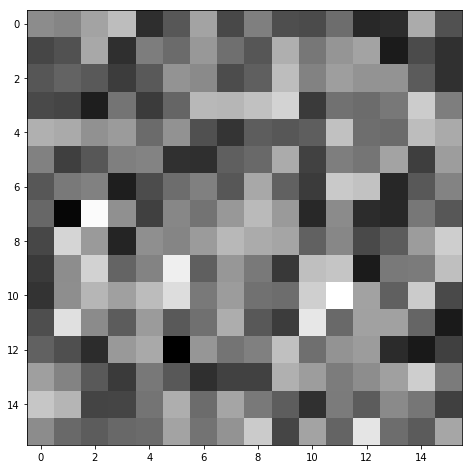

(16,)


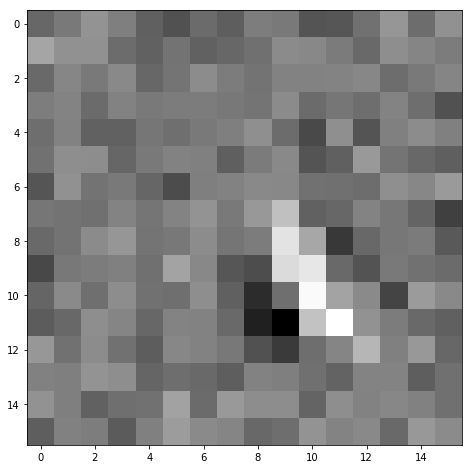

(16,)


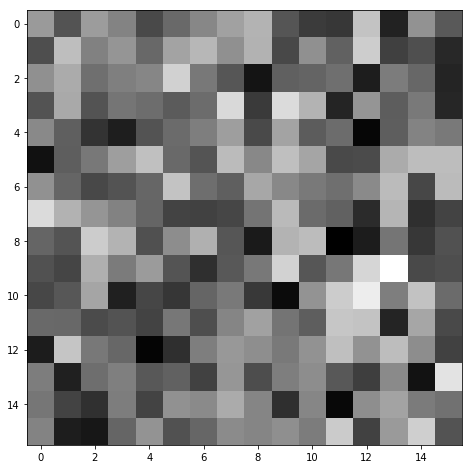

(16,)


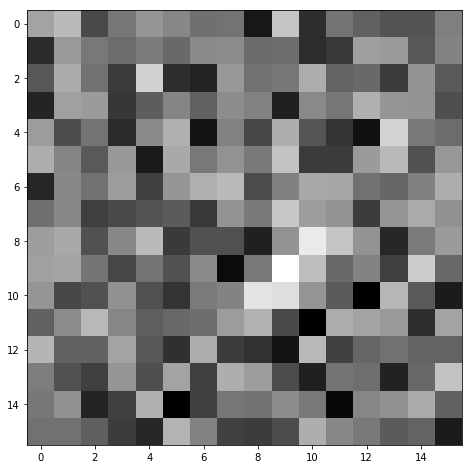

(16,)


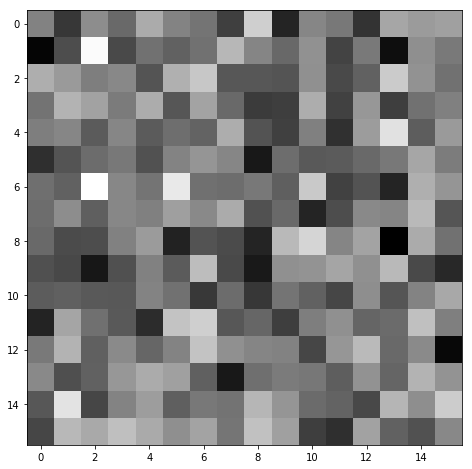

(16,)


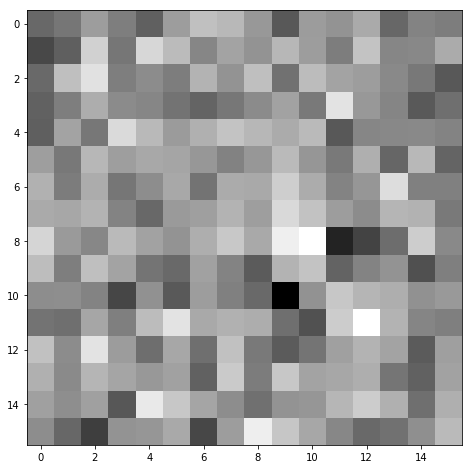

(16,)


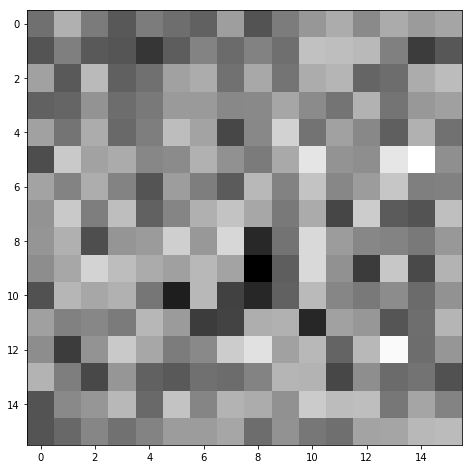

(16,)


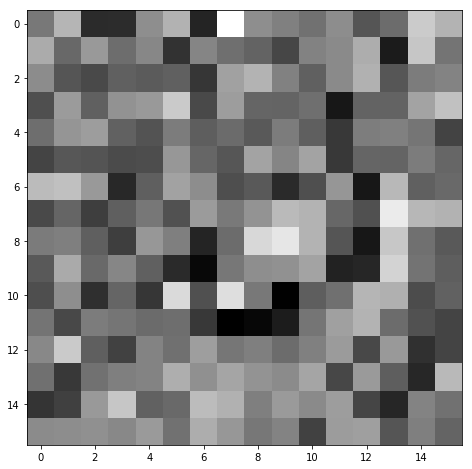

(16,)


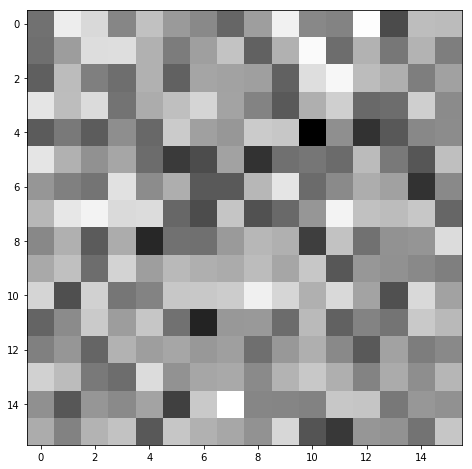

In [190]:
for i in xrange(10):
    wt = weights[0][0][:,i]
    wt = np.reshape(wt, (16,-1))
    avg = np.mean(wt, axis=1)

    plt.imshow(wt)
    plt.show()